<a href="https://colab.research.google.com/github/nyjinnn/images/blob/main/220801_%EC%88%99%EC%A0%9Cver1_Final_quiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. cifar10 
1. 기간 : 8월 6일까지 제출 (~ 23:59) 
  - 결과 공개는 8월 8일
2. 허용 범위
  - convolution
  - dropout 
  - 모든 전처리 방법 ok 
  - 모든 규제 방법 (L1, L2 등) 허용 
  - 모든 activation 허용
  - 모든 normalization 방법 금지 (batch, layer, weight 등등)
  - 재학습했을 때 결과가 동일해야 함
  - 미니 배치 사용 (배치 사이즈 상관없음) 
  - 파이토치만 쓸 것 
  - 앙상블 허용 
3. 기준 
  - 정확도
  - 모델 파라미터 수  
  - 학습 횟수 (배치 사이즈 x 스텝 x 주기) 
4. 포상 
  - 개인 : 2만원 상당의 무언가
  - 팀 : 간식 (3만원?)



In [50]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np 

### 1. 데이터셋 준비하기

In [51]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_train_all.shape, y_train_all.shape)

(50000, 32, 32, 3) (50000, 1)


In [52]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

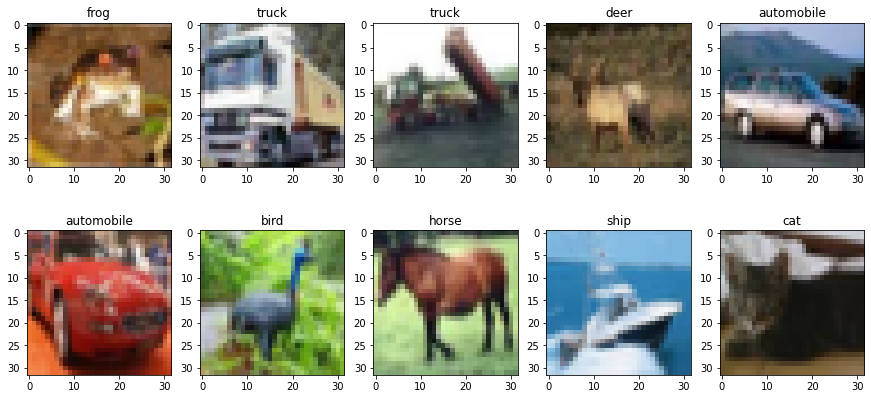

In [53]:
fig = plt.figure(figsize=(15, 7))

for i in range(10):
    plottable_image = x_train_all[i]
    ax = fig.add_subplot(2, 5, i+1)
    ax.title.set_text(class_names[y_train_all[i][0]])
    ax.imshow(plottable_image)

In [54]:
from sklearn.model_selection import train_test_split 
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [55]:
print("학습 데이터셋 클래스별 샘플 수 : ", np.bincount(y_train.reshape(-1)))
print("평가 데이터셋 클래스별 샘플 수 : ", np.bincount(y_valid.reshape(-1)))

학습 데이터셋 클래스별 샘플 수 :  [4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]
평가 데이터셋 클래스별 샘플 수 :  [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


In [84]:
import torch

x_train_torch = torch.FloatTensor(x_train.mean(3))
y_train_torch = torch.FloatTensor(y_train)
x_valid_torch = torch.FloatTensor(x_valid.mean(3))
y_valid_torch = torch.FloatTensor(y_valid) 
x_test_torch = torch.FloatTensor(x_test.mean(3))
y_test_torch = torch.FloatTensor(y_test)

In [85]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
  def __init__(self, x, y):
    self.x_data = x
    self.y_data = y
  
  def __getitem__(self, index):
    x = self.x_data[index]
    y = self.y_data[index]
    return x, y
  
  def collate_fn(self, batch):
    x, y = zip(*batch)
    return x, y

  def __len__(self):
    return len(self.x_data)

dataset = MyDataset(x_train_torch, y_train_torch)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

In [86]:
print(x_train_torch.size())
print(y_train_torch.size())
print(y_train_torch)

torch.Size([40000, 32, 32])
torch.Size([40000, 1])
tensor([[6.],
        [7.],
        [8.],
        ...,
        [1.],
        [9.],
        [3.]])


In [95]:
from tqdm import tqdm 
import random 

random_seed = 123
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding='same'),      
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Conv2d(in_channels=10, out_channels=1, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3),
        nn.Dropout(0.3),
    )
    
    self.linear = nn.Linear(100, 1)
  
  def forward(self, x):
    output = self.net(x)
    output = output.view(-1, 1, 100)
    output = self.linear(output)
    return output

In [96]:
model = MyModel()
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

global_step = 0 
for epoch in range(10):
  t = tqdm(dataloader, ncols=100)
  for i, batch in enumerate(t):
    x_batch = batch[0]
    y_batch = batch[1]
    output = model(x_batch.unsqueeze(1))
    loss = criterion(output.squeeze(1), y_batch)
    model.zero_grad() 
    optim.zero_grad()
    loss.backward()
    optim.step()

    global_step += 1
    t.set_description("epoch: {} | global_step: {:8d} | loss: {:.4f}".format(epoch + 1, global_step, loss))

  with torch.no_grad():
    model.eval()
    predicts = model(x_valid_torch.unsqueeze(1))
    predicts = predicts.squeeze(1) #torch.argmax(predicts.squeeze(1), 1)

    correct = 0 
    for i in range(len(predicts)):
      if predicts[i].item() == y_valid[i]:
        correct += 1
    acc = correct / len(predicts)
    print("epoch: {} | global_step: {} | valid acc: {:%}".format(epoch + 1, global_step, acc))
    model.train()

epoch: 1 | global_step:      505 | loss: -0.0000:  40%|████      | 505/1250 [00:11<00:17, 43.65it/s]


KeyboardInterrupt: ignored